<a href="https://colab.research.google.com/github/harshitha2403/Hate-Speech-Detection/blob/main/Final_HSB_Roberta_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import precision_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_metric
import torch
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [ ]:
#Loading the dataset
train = pd.read_csv("drive/My Drive/HSB/trainHSB.csv")
test = pd.read_csv("drive/My Drive/HSB/testHSB.csv")

In [ ]:
#sving it to csv
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [ ]:
print(train.shape)
train.head()

(37500, 2)


,text,label
0,it s mind boggling to me i mean they just cut ...,0
1,any vitim zeist is any track make off porrima ...,1
2,you making no sense antifa is a cut and it mea...,1
3,well if you reported it then your can kiss me ...,1
4,politician work group yes politician priority ...,0


In [ ]:
print(test.shape)
test.head()

(12500, 2)


,text,label
0,murray cod hi conman whatever have been throug...,0
1,to address ok if those as as nlp authors can g...,0
2,please read profound comments above you commen...,0
3,scholar does not mention an of but an of that ...,0
4,this is how her mod attributed to deleting com...,1


In [ ]:
# Loading the dataset
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

In [ ]:
#Initializing the tokenizer and the model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

#tokenizing
tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/37500 [00:00<?, ? examples/s]

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

In [ ]:
#collecting function
def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.tensor([item['labels'] for item in batch])
    }

train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["test"]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    evaluation_strategy="steps",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.494000,0.421080,0.821520,0.817356,0.836882,0.798720
1000,0.402000,0.342668,0.846640,0.848948,0.836361,0.861920
1500,0.318100,0.375941,0.844560,0.834427,0.892616,0.783360
2000,0.276000,0.341346,0.858320,0.855864,0.870962,0.841280
2500,0.239800,0.384404,0.859760,0.853293,0.894543,0.815680
3000,0.174600,0.404274,0.855280,0.845319,0.907805,0.790880
3500,0.169200,0.438811,0.858400,0.850859,0.898718,0.807840
4000,0.108400,0.559779,0.859680,0.852803,0.896753,0.812960
4500,0.100700,0.570169,0.847200,0.834173,0.911921,0.768640
5000,0.081400,0.638220,0.860960,0.852787,0.906048,0.805440


TrainOutput(global_step=5860, training_loss=0.2108655014949447, metrics={'train_runtime': 4928.4122, 'train_samples_per_second': 38.045, 'train_steps_per_second': 1.189, 'total_flos': 1.233333072e+16, 'train_loss': 0.2108655014949447, 'epoch': 5.0})

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      6250
           1       0.91      0.79      0.85      6250

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



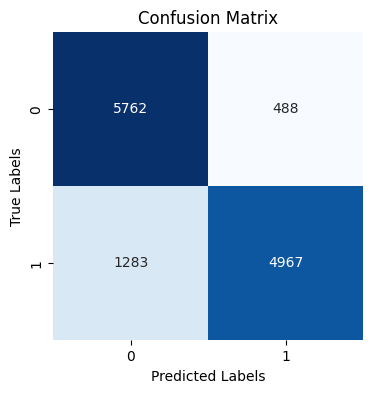

In [ ]:
predictions = trainer.predict(eval_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

print("Classification Report:\n", classification_report(true_labels, predicted_labels))

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#epoch = 3
'''
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=4,              # Number of epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=500,
    evaluation_strategy="steps",     # Evaluate every 'logging_steps'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics  # Define your metric computation function
)

trainer.train()
'''

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.528100,0.458013,0.790500,0.764739,0.858764,0.689271
1000,0.394700,0.393655,0.836000,0.835507,0.828032,0.843117
1500,0.197000,0.542676,0.836500,0.829243,0.856526,0.803644


TrainOutput(global_step=1500, training_loss=0.37325826517740884, metrics={'train_runtime': 620.0402, 'train_samples_per_second': 38.707, 'train_steps_per_second': 2.419, 'total_flos': 1578666332160000.0, 'train_loss': 0.37325826517740884, 'epoch': 3.0})